In [359]:
# Import necessary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [360]:
path = Path.cwd() / 'ece661_pics' / 'hw11_image' / 'Task2'
np.set_printoptions(precision=5)

In [361]:
class Image():
    ''' 
        Class for storing images.
    '''
    
    def __init__(self, path):
        self.path = path   

    def load(self):
        filename = f'{self.path.parent}/{self.path.name}'
        self.image = cv.imread(filename)

    def show(self):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))
    
    def harr_filter(self):
        # Compute Haar filter for this image
        image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        intergral_image = np.cumsum(np.cumsum(image_gray, axis=1), axis=0)
        h, w = image_gray.shape
        # Horizontal Haar kernals
        h_kernels = []
        for i in range(1, int(w/2) + 1):
            zero = np.zeros((1, i))
            one = np.ones((1, i))
            kernel = np.hstack((zero, one))
            h_kernels.append(kernel)
        # Vertical Haar kernals
        v_kernels = []
        for i in range(1, int(h/2) + 1):
            zero = np.zeros((i, 2))
            one = np.ones((i, 2))
            kernel = np.vstack((one, zero))
            v_kernels.append(kernel)
            features = []
        # Apply horizontal Haar filter
        for kernel in h_kernels:
            kh, kw = kernel.shape
            for i in range(w - kw):
                for j in range(h - kh):
                    top_left = intergral_image[j, i]
                    top_mid = intergral_image[j, i+int(kw/2)]
                    top_right = intergral_image[j, i+kw]
                    bot_left = intergral_image[j+kh, i]
                    bot_mid = intergral_image[j+kh, i+int(kw/2)]
                    bot_right = intergral_image[j+kh, i+kw]
                    feature = bot_right - \
                            2 * bot_mid + \
                            2 * top_mid - \
                            top_right + \
                            bot_left - \
                            top_left
                    features.append(feature)
        # Apply vertical Haar filter
        for kernel in v_kernels:
            kh, kw = kernel.shape
            for i in range(w - kw):
                for j in range(h - kh):
                    left_top = intergral_image[j ,i]
                    left_mid = intergral_image[j+int(kh/2) ,i]
                    left_bot = intergral_image[j+kh ,i]
                    right_top = intergral_image[j ,i+kw]
                    right_mid = intergral_image[j+int(kh/2) ,i+kw]
                    right_bot = intergral_image[j+kh ,i+kw]
                    feature = left_top - \
                            2 * left_mid + \
                            2 * right_mid - \
                            right_top + \
                            left_bot - \
                            right_bot
                    features.append(feature)

        features = np.array(features)
        return features

In [362]:
# Load dataset train positive
train_positive = []
for x in tqdm((path / 'train' / 'positive').iterdir()):
    image = Image(x)
    # Skip Window's system file 
    if image.path.suffix == '.db':
        continue
    image.load()
    feature = image.harr_filter()
    train_positive.append(feature)
train_positive = np.array(train_positive).T

710it [01:18,  9.06it/s]


In [363]:
# Load dataset train negative
train_negative = []
for x in tqdm((path / 'train' / 'negative').iterdir()):
    image = Image(x)
    # Skip Window's system file 
    if image.path.suffix == '.db':
        continue
    image.load()
    feature = image.harr_filter()
    train_negative.append(feature)
train_negative = np.array(train_negative).T

1758it [02:58,  9.85it/s]


In [364]:
# Load dataset test positive
test_positive = []
for x in tqdm((path / 'test' / 'positive').iterdir()):
    image = Image(x)
    # Skip Window's system file 
    if image.path.suffix == '.db':
        continue
    image.load()
    feature = image.harr_filter()
    test_positive.append(feature)
test_positive = np.array(test_positive).T

179it [00:21,  8.47it/s]


In [365]:
# Load dataset test negative
test_negative = []
for x in tqdm((path / 'test' / 'negative').iterdir()):
    image = Image(x)
    # Skip Window's system file 
    if image.path.suffix == '.db':
        continue
    image.load()
    feature = image.harr_filter()
    test_negative.append(feature)
test_negative = np.array(test_negative).T

441it [00:46,  9.41it/s]


In [366]:
def compute_cascade(train_set, n_train_positive, n_train_negative):
    ''' 
        Find best week classifier and update weight until 
        reaching target false positive rate.
    '''
    false_positive_target = 0.5
    train_label = np.concatenate((np.ones(n_train_positive), np.zeros(n_train_negative)))
    # Compose normalized weight
    weight_positive = np.ones(n_train_positive) / (2 * n_train_positive)
    weight_negative = np.ones(n_train_negative) / (2 * n_train_negative)
    weight_norm = np.concatenate((weight_positive, weight_negative))
    alphas = []
    classifiers = []
    hs = []
    for t in range(50):
        best_error = np.inf
        total_positive = np.sum(weight_norm[:n_train_positive])
        total_negative = np.sum(weight_norm[n_train_positive:])
        for i in range(n_feature):
            feature = train_set[i]
            labels = train_label
            weight = weight_norm
            # Sorting by the feature values
            indices = np.argsort(feature)
            feature = feature[indices]
            labels = labels[indices]
            weight = weight[indices]
            # Compute error
            sum_positive = np.cumsum(weight * labels)
            sum_negative = np.cumsum(weight) - sum_positive
            error1 = sum_positive + (total_negative - sum_negative)
            error2 = sum_negative + (total_positive - sum_positive)
            error = np.minimum(error1, error2)
            min_index = np.argmin(error)
            # Keep the result if it is the best
            if error[min_index] < best_error:
                best_error = error[min_index]
                if error1[min_index] <= error2[min_index]:
                    polarity = 1
                    result = train_set[i] >= feature[min_index]
                else:
                    polarity = -1
                    result = train_set[i] < feature[min_index]
                result = result.astype(np.uint8)
                mismatch = result != train_label
                mismatch = mismatch.astype(np.uint8)
                n_mismatch = np.sum(mismatch)
                classifier = {
                    'index': i,
                    'polarity': polarity,
                    'n_mismatch': n_mismatch,
                    'epsilon': best_error,
                    'theta': feature[min_index]
                }
        # Update weight
        epsilon = classifier['epsilon']
        beta = epsilon / (1 - epsilon)
        weight_norm = weight_norm * np.power(beta, 1 - mismatch)
        weight_norm = weight_norm / weight_norm.sum()
        # Check performance
        alpha = np.log(1 / beta)
        alphas.append(alpha)
        classifiers.append(classifier)
        hs.append(result)
        h_np = np.array(hs).T
        alpha_np = np.array(alphas).T
        C = np.dot(h_np, alpha_np)
        threshole = np.min(C[:n_train_positive])
        C = (C >= threshole).astype(np.uint8)
        false_positive = np.sum(C[n_train_positive:]) / n_train_negative
        true_positive = np.sum(C[:n_train_positive]) / n_train_positive
        if false_positive < false_positive_target:
            print(f'True Positive = {true_positive:.3f} False Positive = {false_positive:.3f}')
            break

    # Filter true negative out
    false_positive_indices = np.argwhere(C[n_train_positive:] == 1).ravel() 
    false_positive_indices = false_positive_indices + n_train_positive
    false_positive_features = train_set[:, false_positive_indices]
    new_train_set = np.hstack((train_set[:, :n_train_positive], false_positive_features))
    new_n_train_negative = false_positive_indices.shape[0]

    return [new_train_set, new_n_train_negative, 
            false_positive, true_positive, 
            len(classifiers), classifiers, alphas]

In [367]:
# Perform classifier on training set
train_set = np.hstack((train_positive, train_negative))
n_train_positive = train_positive.shape[1]
n_train_negative = train_negative.shape[1]
false_positive_rates = []
true_positive_rates = []
n_classifier = []
classifiers = []
alphas = []
n_train_negative_list = []
false_positive_target = 1e-2
for state in range(10):
    n_train_negative_list.append(n_train_negative)
    outcome = compute_cascade(train_set, n_train_positive, n_train_negative)
    train_set = outcome[0]
    n_train_negative = outcome[1]
    false_positive_rates.append(outcome[2])
    true_positive_rates.append(outcome[3])
    n_classifier.append(outcome[4])
    classifiers.append(outcome[5])
    alphas.append(outcome[6])
    if false_positive_rates[-1] < false_positive_target or \
       n_train_negative < 1:
       break

True Positive = 1.000 False Positive = 0.474
True Positive = 1.000 False Positive = 0.442
True Positive = 1.000 False Positive = 0.434
True Positive = 1.000 False Positive = 0.494
True Positive = 1.000 False Positive = 0.291
True Positive = 1.000 False Positive = 0.478
True Positive = 1.000 False Positive = 0.364
True Positive = 1.000 False Positive = 0.000


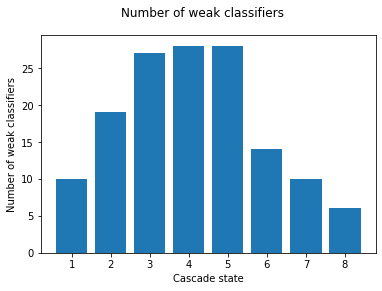

In [368]:
fig, ax = plt.subplots()
fig.suptitle('Number of weak classifiers')
plt.xlabel('Cascade state')
plt.ylabel('Number of weak classifiers')
ax.bar(np.arange(1, state+2), n_classifier)
filename = path / 'n_classifier.png'
plt.savefig(filename)

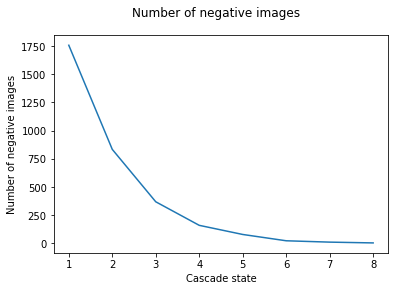

In [369]:
fig, ax = plt.subplots()
fig.suptitle('Number of negative images')
plt.xlabel('Cascade state')
plt.ylabel('Number of negative images')
ax.plot(np.arange(1, state+2), n_train_negative_list)
filename = path / 'n_neg_image.png'
plt.savefig(filename)

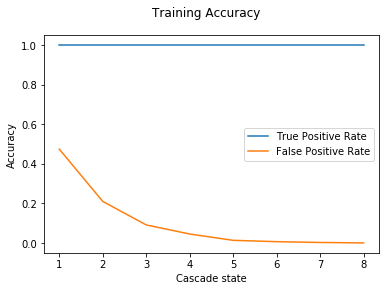

In [370]:
fig, ax = plt.subplots()
fig.suptitle('Training Accuracy')
plt.xlabel('Cascade state')
plt.ylabel('Accuracy')
ax.plot(np.arange(1, state+2), 
        np.cumprod(true_positive_rates), 
        label='True Positive Rate')
ax.plot(np.arange(1, state+2), 
        np.cumprod(false_positive_rates), 
        label='False Positive Rate')
plt.legend(loc='best');
filename = path / 'train_accu.png'
plt.savefig(filename)

In [371]:
# Test with test set
test_set = np.hstack((test_positive, test_negative))
n_test_positive = test_positive.shape[1]
n_test_negative = test_negative.shape[1]
false_positive_rates = []
false_negative_rates = []
for i, weak_classifiers in enumerate(classifiers):
    hs = []
    for classifier in weak_classifiers:
        index = classifier['index']
        threshole = classifier['theta']
        polarity = classifier['polarity']
        feature = test_set[index]
        if polarity == 1:
            result = feature >= threshole
        else:
            result = feature < threshole
        result = np.array(result, dtype=np.uint8)
        hs.append(result)
    
    hs = np.array(hs).T
    alpha = np.array(alphas[i]).T
    C = np.dot(hs, alpha)
    threshole_alpha = np.sum(alpha) * 0.5
    C = C >= threshole_alpha
    C = C.astype(np.uint8)
    # Filter false negative out for next round
    true_positive_indices = np.argwhere(C[:n_test_positive] == 1).ravel()
    true_positive_feature = test_set[:, true_positive_indices]
    n_false_negative = n_test_positive - true_positive_indices.shape[0]
    false_negative_rates.append(n_false_negative)
    # Filter true negative out for the next round
    false_positive_indices = np.argwhere(C[n_test_positive:] == 1).ravel()
    false_positive_indices = false_positive_indices + n_test_positive
    false_positive_feature = test_set[:, false_positive_indices]
    n_false_positive = false_positive_indices.shape[0]
    false_positive_rates.append(n_false_positive)
    # Update testing set
    test_set = np.hstack((true_positive_feature, false_positive_feature))
    n_test_positive = true_positive_indices.shape[0]

n_test_positive = test_positive.shape[1]
n_test_negative = test_negative.shape[1]
false_negative_rates = np.array(false_negative_rates)
false_negative_rates = false_negative_rates / n_test_positive
false_positive_rates = np.array(false_positive_rates)
false_positive_rates = false_positive_rates / n_test_negative

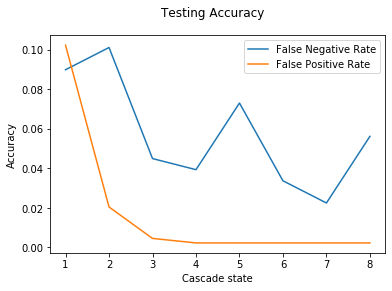

In [372]:
fig, ax = plt.subplots()
fig.suptitle('Testing Accuracy')
plt.xlabel('Cascade state')
plt.ylabel('Accuracy')
ax.plot(np.arange(1, state+2), 
        false_negative_rates, 
        label='False Negative Rate')
ax.plot(np.arange(1, state+2), 
        false_positive_rates, 
        label='False Positive Rate')
plt.legend(loc='best');
filename = path / 'test_accu.png'
plt.savefig(filename)